# Анализ показателей приложения Procrastinate Pro+

**Цель исследования** - на основе анализа бизнес-показателей найти причину убытков компании в последние несолько месяцев и помочь ей выйти в плюс.

Необходимо изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

**Ход исследования**

Исходные данные - данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Ислледование пройдет в четыре этапа:
1. Предобработка данных.
2. Исследовательский анализ данных.
3. Расчет маркетинговых показателей.
4. Оценка окупаемости рекламы.

## Предобработка данных

Импортируем необходимые библиотеки и сохраняем исходные файлы в переменных.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
try:
    visits, orders, costs = (
    pd.read_csv(r'C:\Users\м\Documents\Data\visits_info_short.csv'),  #журнал сессий
    pd.read_csv(r'C:\Users\м\Documents\Data\orders_info_short.csv'),  #покупки
    pd.read_csv(r'C:\Users\м\Documents\Data\costs_info_short.csv')    #траты на рекламу
    )
except:
    visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),
    pd.read_csv('/datasets/orders_info_short.csv'),
    pd.read_csv('/datasets/costs_info_short.csv')
    )

Выведем первые строки таблиц на экран:

In [3]:
display(visits.head())
display(orders.head())
display(costs.head())

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Согласно документации к данным:

В таблице `visits` шесть столбцов:
- `User Id` — уникальный идентификатор пользователя,
- `Region` — страна пользователя,
- `Device` — тип устройства пользователя,
- `Channel` — идентификатор источника перехода,
- `Session Start` — дата и время начала сессии,
- `Session End` — дата и время окончания сессии.

В таблице `orders` три столбца:
- `User Id` — уникальный идентификатор пользователя,
- `Event Dt` — дата и время покупки,
- `Revenue` — сумма заказа.

И в таблице `costs` три столбца:
- `Channel` — идентификатор рекламного источника,
- `Dt` — дата проведения рекламной кампании,
- `Costs` — расходы на эту кампанию.

Для удобства обращения приведем все названия столбцов к единому формату:

In [4]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns.values]

Выведем теперь информацию о датафреймах:

In [5]:
display(visits.info())
display(orders.info())
display(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

Пропусков нет, но во всех трех таблицах даты записаны в неправильном формате (строковом). Приведем данные к нужному типу.

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'], format='%Y-%m-%d %H:%M:%S')
visits['session_end'] = pd.to_datetime(visits['session_end'], format='%Y-%m-%d %H:%M:%S')
orders['event_dt'] = pd.to_datetime(orders['event_dt'], format='%Y-%m-%d %H:%M:%S')
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d') 

Проверяем внесенные изменения:

In [7]:
display(visits[['session_start', 'session_end']].dtypes)
display(orders[['event_dt']].dtypes)
display(costs[['dt']].dtypes)

session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object

event_dt    datetime64[ns]
dtype: object

dt    datetime64[ns]
dtype: object

Теперь проверим таблицы на наличие дубликатов:

In [8]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


Явных строк-дубликатов в датафреймах нет. Изучим еще некоторые данные, с которыми будем работать в дальнейшем.

In [9]:
visits['region'].value_counts()

United States    207327
UK                36419
France            35396
Germany           30759
Name: region, dtype: int64

Всего приложением пользуются в четырех странах: США, Великобритании, Франции, Германии. При этом логов из США в два раза больше, чем всех остальных вместе взятых.

In [10]:
len(visits['channel'].unique())

11

В приложение попадают по 11 разным источникам.

In [11]:
visits['device'].value_counts()

iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64

Procrastinate Pro+ используют на iPhone, Android, PC и Mac.

In [12]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Рекламных источников у компании 10.

In [13]:
orders['revenue'].describe()

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

В среднем пользователи совершают покупки на 5.37. Медианное значение чуть ниже - 4.99, оно совпадает с минимальным. Максимальное значение - 49.99.

In [14]:
costs['costs'].describe()

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

Затраты на рекламную кампанию варьируются от 0.8 до 630. Среднее значение - 58.6, медианное значение заметно меньше - 12.3. В связи с этим можно предположить, что цены за рекламу на разных источниках сильно отличаются.  

**Вывод:**
На данном этапе мы подготовили данные к дальнейшему исследовательскому анализу. Мы привели все названия столбцов к единообразию, проверили данные на наличие полных дубликатов, изменили тип данных, где необходимо. Также мы изучили некоторые категориальные и количественные переменные и узнали, что пользователями Procrastinate Pro+ являются граждане четырех стран (США, Великобритания, Франция, Германия). Больше всего клиентов у компании из США. Приложение используют на девайсах iPhone, Android, PC и Mac. Средняя сумма заказов пользователей - 5.37 у.е., а средние затраты на рекламную кампанию - 58.6 у.е. 

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

Зададим функции для создания профилей, расчёта удержания, конверсии, LTV и ROI: `get_profiles()`, `get_retention()`, `get_conversion()` и `get_ltv()`:

In [15]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Функция для расчёта удержания:

In [16]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Функция для расчёта конверсии:

In [17]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Функция для расчёта LTV и ROI:

In [18]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Также зададим функции для визуализации этих метрик — `filter_data()`, `plot_retention()`, `plot_conversion()` и `plot_ltv_roi()`.

In [19]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

Функция для визуализации удержания:

In [20]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

Функция для визуализации конверсии:

In [21]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

Функция для визуализации LTV и ROI:

In [22]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Исследовательский анализ данных

### Профили пользователей

Вызвав функцию `get_profiles()`, получим профили пользователей.

In [23]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5)) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определим минимальную и максимальную даты привлечения пользователей:

In [24]:
min_analysis_date = profiles['dt'].min()
observation_date =  profiles['dt'].max()

print(min_analysis_date, '\n', observation_date)

2019-05-01 00:00:00 
 2019-10-27 00:00:00


Получившийся диапазон дат - с 1 мая 2019 по 27 октября 2019, находится в пределах дат, определенных в исходных данных.

### Определение страны с наибольшим числом платящих пользователей

Построим таблицу с количеством пользователей из разных стран и долей платящих из них.

In [25]:
(profiles
    .groupby('region')
    .agg({'user_id': 'count',
         'payer': 'mean'})
    .sort_values(by='payer', ascending=False)
    .style.format({'payer': '{:.1%}'})
)

,user_id,payer
region,,
United States,100002,6.9%
Germany,14981,4.1%
UK,17575,4.0%
France,17450,3.8%


Больше всего доля платящих пользователей в США - почти 7% от общего числа юзеров из этой страны что-либо покупали в приложении. В других странах таких пользователей только около 4%.

### Определение предпочтений платящих пользователей относительно устройств

Теперь посмотрим на разбивку пользователей по девайсам, с которых они заходят в приложение.

In [26]:
(profiles
    .groupby('device')
    .agg({'user_id': 'count',
         'payer': 'mean'})
    .sort_values(by='payer', ascending=False)
    .style.format({'payer': '{:.1%}'})
)

,user_id,payer
device,,
Mac,30042,6.4%
iPhone,54479,6.2%
Android,35032,5.9%
PC,30455,5.0%


Бо́льшая часть пользователей приложения предпочитает iPhone, но доля платящих клиентов чуть выше среди тех, кто пользуется устройствами Mac - 6.4% против 6.2%.

### Определение самых эффективных каналов по привлечению платящих пользователей

Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения:

In [27]:
(profiles
    .groupby('channel')
    .agg({'user_id': 'count',
         'payer': 'mean'})
    .sort_values(by='payer', ascending=False)
    .style.format({'payer': '{:.1%}'})
)

,user_id,payer
channel,,
FaceBoom,29144,12.2%
AdNonSense,3880,11.3%
lambdaMediaAds,2149,10.5%
TipTop,19561,9.6%
RocketSuperAds,4448,7.9%
WahooNetBanner,8553,5.3%
YRabbit,4312,3.8%
MediaTornado,4364,3.6%
LeapBob,8553,3.1%


Доля покупателей выше всего среди пользователей, пришедших из источников: "FaceBoom", "AdNonSense", "lambdaMediaAds" - 12%, 11% и 10% соответственно. Хуже всего конвертируются в покупателей пользователи, привлеченные органическим путем (доля плательщиков всего 2%). Но в целом таких клиентов у компании больше всего. 

**Вывод:** мы получили профили пользователей приложения и нашли минимальную и максимальную даты их привлечения. Это 01.05.2019 и 27.10.2019 соответственно. Мы определили, что больше всего юзеров Procrastinate Pro+ из США (100002 пользователя) и они же (относительно пользователей из других стран) лучше всего конвертируются в покупателей. Что касается устройств, с которых клиенты заходят в приложение, самая большая доля у iPhone (остальные - Mac, Android, PC примерно на одном уровне). Однако конвертируемость в платящих пользователей чуть выше у владельцев Mac. Также мы определили, что бо́льшая часть клиентов компании - органическая аудитория, но доля покупателей среди самая низкая по сравнению с другими источниками привлечения. Лидерами по этому показателю являются "FaceBoom", "AdNonSense", "lambdaMediaAds" - как минимум, каждый десятый пользователь, привлеченный данными каналами, принес компании прибыль. 

## Изучение маркетинговых показателей

### Сумма расходов на маркетинг

Найдем общую сумму расходов на маркетинг:

In [28]:
costs['costs'].sum()

105497.30000000002

Всего в период с 1 мая по 27 октября 2019 года компанией было куплено рекламы на сумму 105497.3 у.е.

Посмотрим, как распределялись затраты по рекламным источникам: 

In [29]:
costs_pivot = costs.pivot_table(index = 'channel', values = 'costs', aggfunc = 'sum').sort_values(
    by='costs',ascending=False).reset_index()
costs_pivot['share'] = costs_pivot['costs'] / costs['costs'].sum()
costs_pivot['share'] = costs_pivot['share'].transform(lambda x: '{:,.2%}'.format(x))
costs_pivot

,channel,costs,share
0,TipTop,54751.30,51.90%
1,FaceBoom,32445.60,30.75%
2,WahooNetBanner,5151.00,4.88%
3,AdNonSense,3911.25,3.71%
4,OppleCreativeMedia,2151.25,2.04%
5,RocketSuperAds,1833.00,1.74%
6,LeapBob,1797.60,1.70%
7,lambdaMediaAds,1557.60,1.48%
8,MediaTornado,954.48,0.90%
9,YRabbit,944.22,0.90%


Больше 50% всех расходов на маркетинг приходится на канал "TipTop". И еще около 30% трат - на канал "FaceBoom".

Теперь построим график изменения общих расходов во времени.

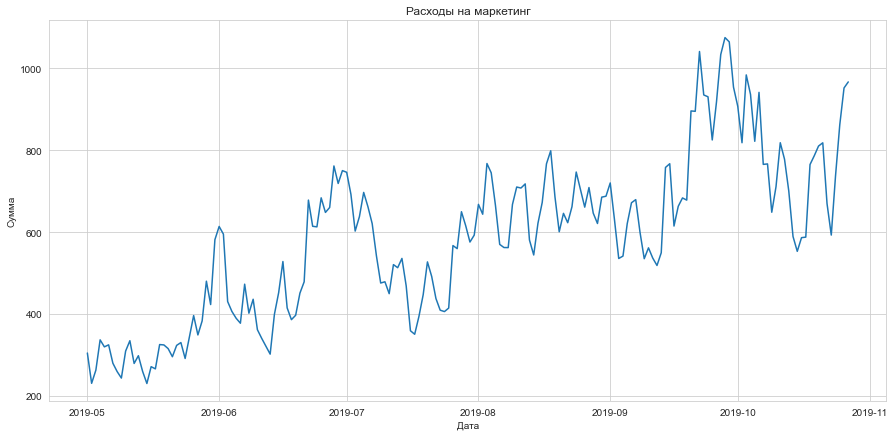

In [30]:
costs_change = costs.pivot_table(index = 'dt', values = 'costs', aggfunc = 'sum').reset_index()
plt.figure(figsize=(15, 7))
sns.set_style('whitegrid')
sns.lineplot(data = costs_change, x = 'dt', y = 'costs').set(
    title = 'Расходы на маркетинг', xlabel = 'Дата', ylabel = 'Сумма')
plt.show() ;

Видим, что несмотря на некоторые "провалы" на графике, в целом затраты на рекламу растут от месяца к месяцу.

Построим такой же график для каждого источника:

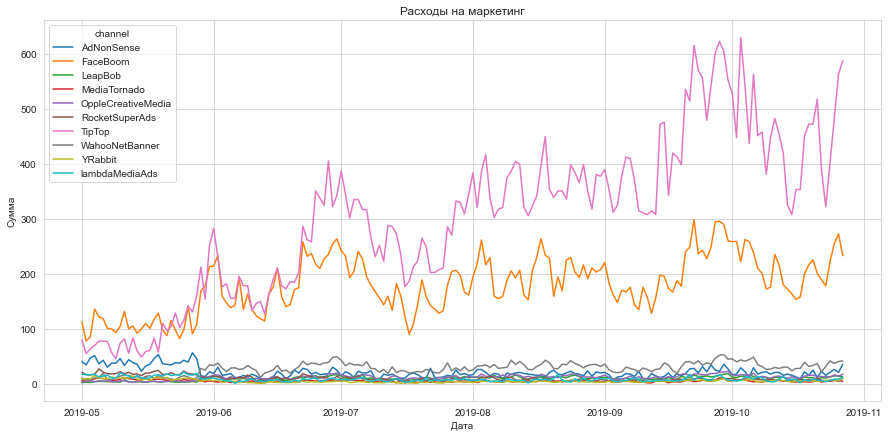

In [31]:
costs_dt = costs.pivot_table(index=['channel','dt'], values='costs', aggfunc='sum').reset_index()
plt.figure(figsize=(15, 7))
sns.set_style('whitegrid')
sns.lineplot(data = costs_dt, x = 'dt', y = 'costs', hue = 'channel').set(
    title = 'Расходы на маркетинг', xlabel = 'Дата', ylabel = 'Сумма')
plt.show() ;


Лидирует с большим отрывом канал "TipTop" - расходы на рекламу на нем растут с каждым месяцем. Много средств также уходит каналу "FaceBoom". Но, если на нем стоимость рекламы не была выше 300 у.е., то на "TipTop", наоборот, с конца июля показатель не опускался ниже 300, а на пике затраты рекламы были больше 600 у.е.!

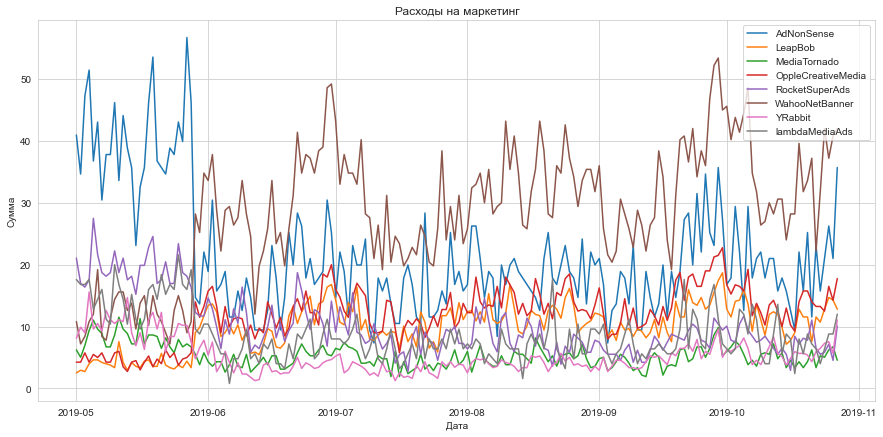

In [32]:
plt.figure(figsize=(15, 7))
sns.set_style('whitegrid')
sns.lineplot(data = costs_dt.query('channel != "TipTop" and channel != "FaceBoom"'), x = 'dt', y = 'costs', hue = 'channel')\
.set(title = 'Расходы на маркетинг', xlabel = 'Дата', ylabel = 'Сумма')
plt.legend(loc = "upper right")
plt.show() ;

Расходы на рекламу на остальных источниках совсем незначительные. Стоимость рекламной кампании не выше 60 у.е.

### Расчет среднего CAC

Найдем среднюю стоимость привлечения одного пользователя. Для этого обратимся к столбцу `acquisition_cost` таблицы `profiles`.

In [33]:
profiles['acquisition_cost'].mean()

0.7032778251826568

Однако, как мы помним, в таблице есть данные о пользователях, пришедших в приложение естественным путем. Стоимость их привлечения мы обозначили нулем, а, так как таких пользователей достаточно много, корректней будет рассчитать среднюю стоимость одного привлечения без них.   

In [34]:
profiles[profiles['channel'] != 'organic']['acquisition_cost'].mean()

1.1274813239427588

Итак, в среднем, чтобы привлечь одного пользователя нужно потратить 1.12 у.е. Теперь рассчитаем средний CAC на одного пользователя для каждого источника трафика.

In [35]:
(profiles
    .pivot_table(index = 'channel', values = 'acquisition_cost', aggfunc = 'mean')
    .sort_values(by = 'acquisition_cost', ascending=False)
    .style.format({'acquisition_cost': '{:.2f}'})
)

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Средний CAC для канала "TipTop" составляет 2.8, что в два с половиной раза больше среднего показателя для всего проекта. Для "FaceBoom" и "AdNonSense" средняя стоимость привлечения одного пользователя почти равна общему среднему. Для остальных каналов CAC меньше 1 у.е.

**Вывод:** Общая сумма расходов на маркетинг в исследуемый период составила 105497.3 у.е. Больше всего денег тратится на покупку рекламы на каналах "TipTop" (больше 50% всех расходов на рекламу) и "FaceBoom" (больше 30%). Расходы на маркетинг планомерно увеличиваются от месяца к месяцу как в целом, так и на канале "TipTop". Затраты на все остальные источники несущественны. Средняя стоимость привлечения одного пользователя составляет 1.12 у.е. Если смотреть в разбивке по каналам привлечения, в лидерах снова оказывается "TipTop" - за одного пользователя придется "заплатить" целых 2.8 у.е.

## Оценка окупаемости рекламы

### Общая окупаемость рекламы

Прежде всего зададим момент и горизонт анализа. Сегодня - 01.11.2019, рассматривать будем пользователей, которые успели "прожить" 14 дней. Также исключим из анализа органических пользователей, потому что за их привлечение компания ничего не платит.

In [36]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

profiles = profiles.query('channel != "organic"')

Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI, вызвав функции `get_ltv()` и `plot_ltv_roi()`.

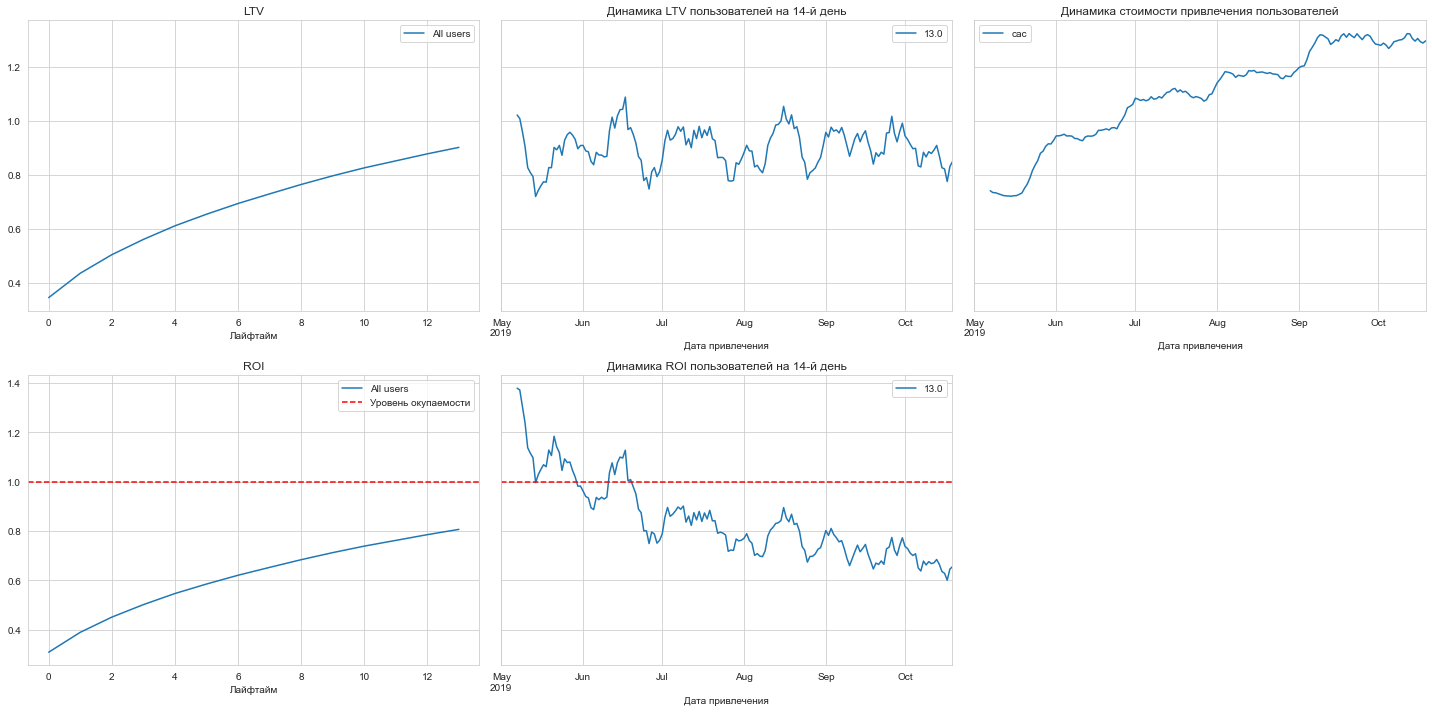

In [37]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
- Реклама не окупается. ROI в конце второй недели — около 80%.
- CAC нестабилен. Рекламный бюджет растет каждый месяц.
- LTV достаточно стабилен. Значит, дело не в ухудшении качества пользователей.
- Динамика ROI пользователей на 14-й день с течением времени падает. В мае и середине июня показатель был выше уровня окупаемости, но сейчас составляет всего 0.6.

Посмотрим, как обстоит дело с общей конверсией и удержанием пользователей.

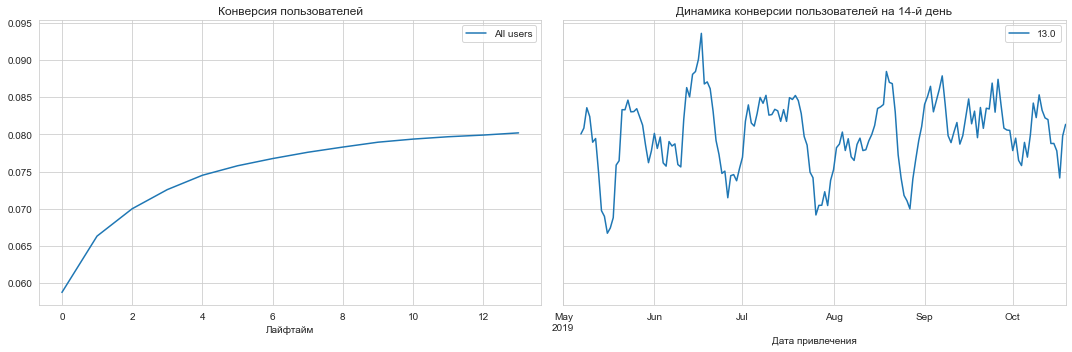

In [38]:
# посмотрим на общую конверсию

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия на 14-й день составляет 8% - неплохой показатель.

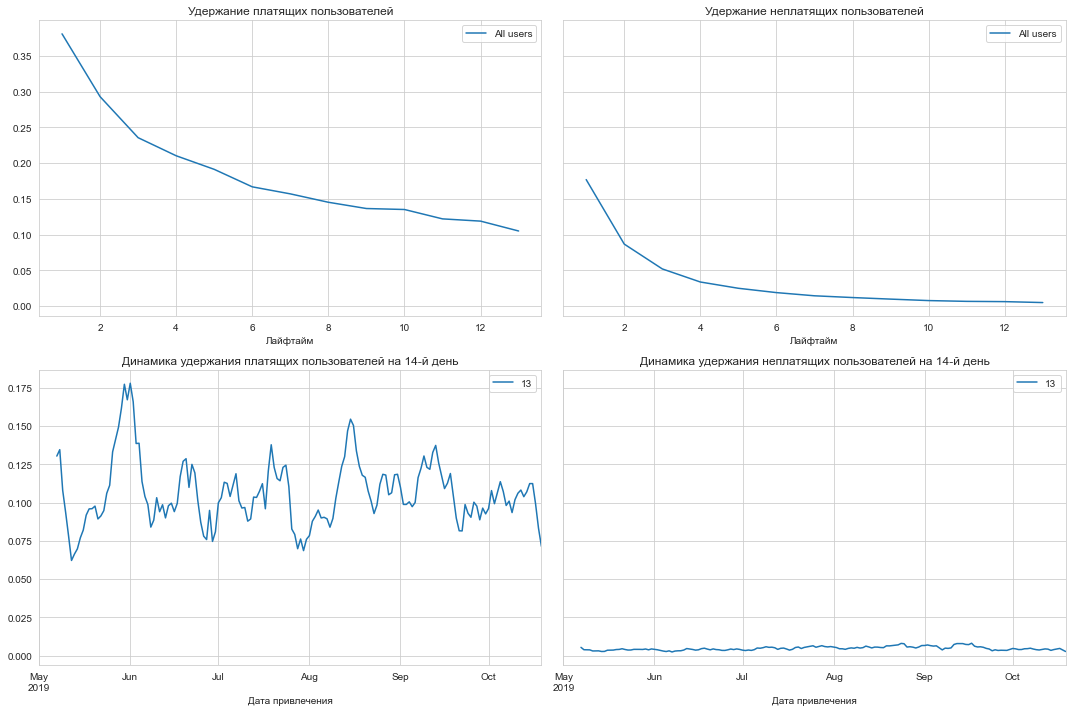

In [39]:
# посмотрим на общее удержание

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание убывает нормально, но в целом показатель достаточно низкий.

Чтобы разобраться в причинах низкого ROI и удержания, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

### Окупаемость рекламы с разбивкой по рекламным каналам

Начнём с разбивки по источникам перехода. Возможно, на окупаемость влияет неудачная реклама в каком-нибудь одном канале. Передадим параметру `dimensions` столбец `channel`.

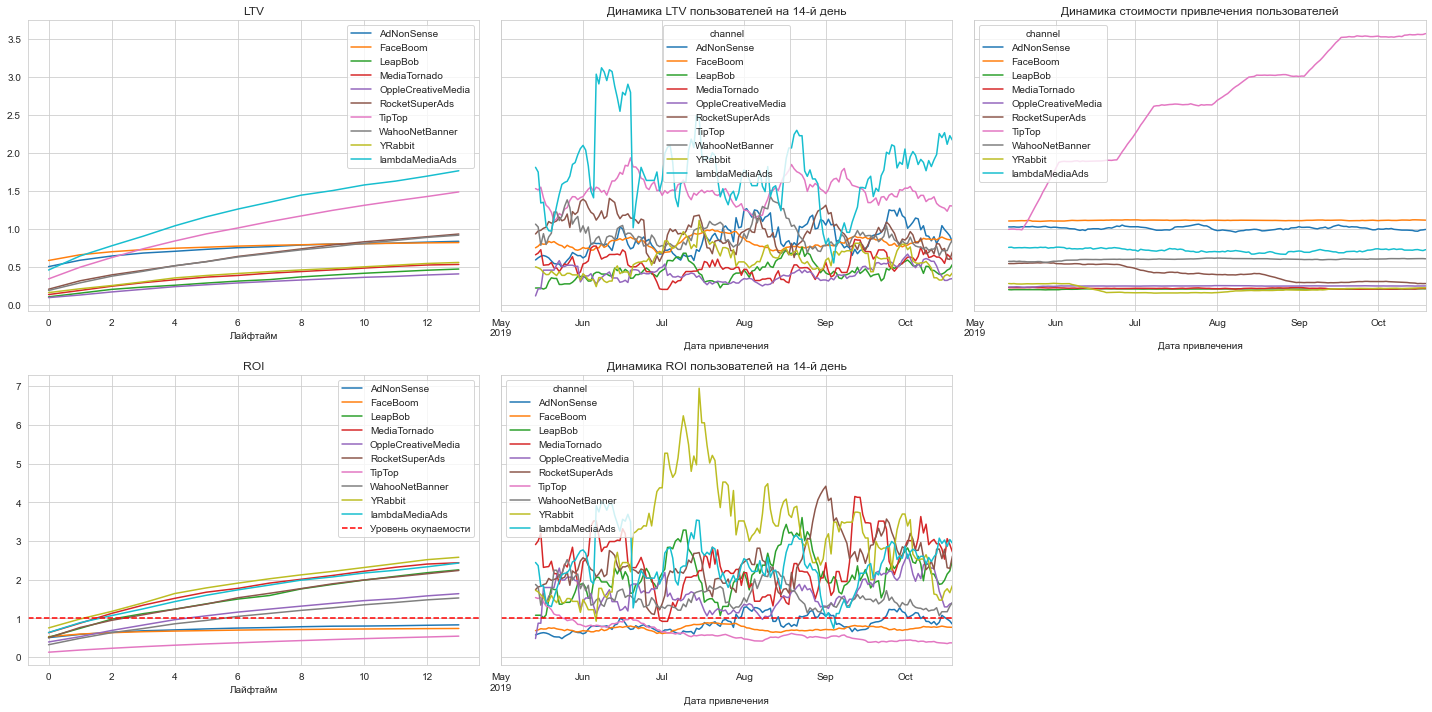

In [40]:
# смотрим окупаемость с разбивкой по каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Похоже, наши опасения оправдались. CAC для канала "TipTop" очень сильно вырос, но реклама на этом источнике совсем не окупается. Как и не окупается реклама на "FaceBoom" и "AdNonSense". С качеством пользователей все в порядке. 

Перейдем к странам.

### Окупаемость рекламы с разбивкой по странам

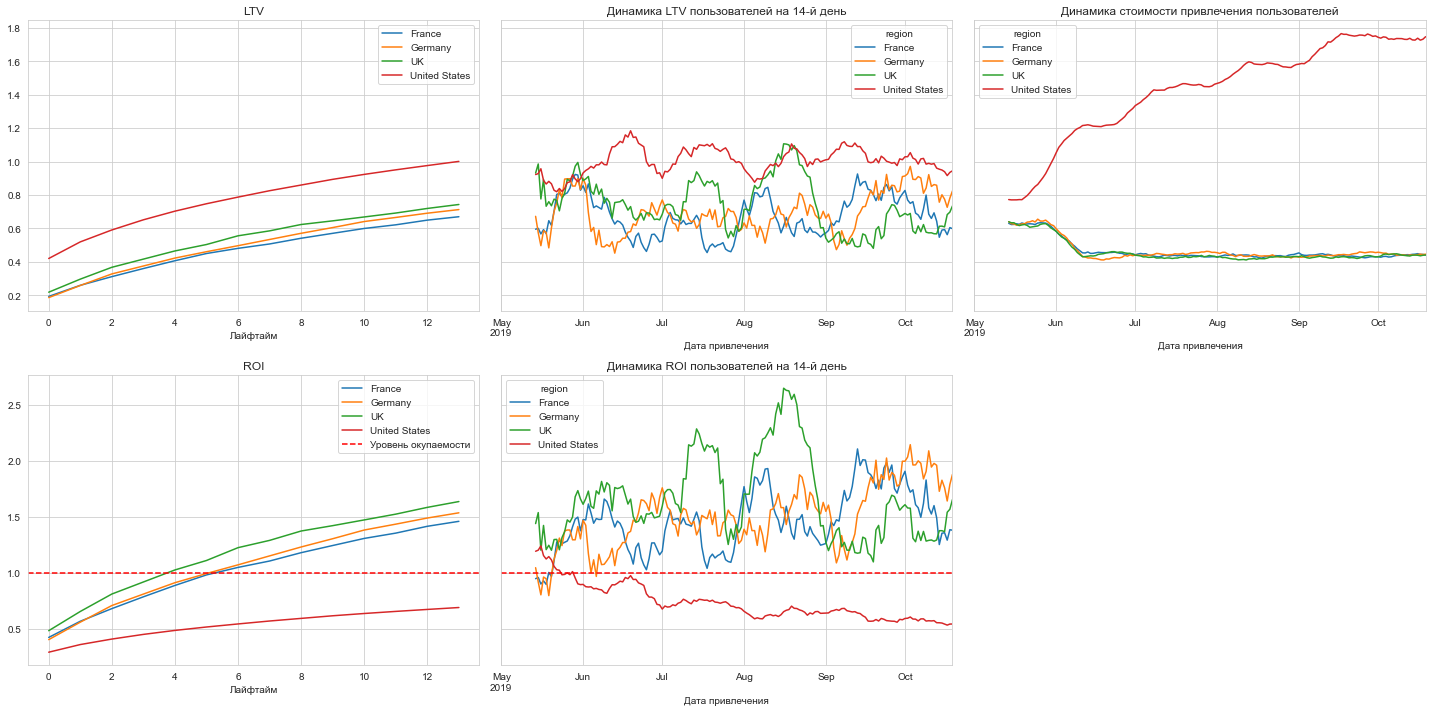

In [41]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Вот что говорят графики:
- В США реклама не окупается совсем. ROI в конце второй недели — около 70%.
- При этом стоимость привлечения пользователей из США очень высока и продолжает расти. В остальных странах CAC стабилен и практически одинаков.
- LTV в целом стабилен.
- Судя по динамике ROI привлечение пользователей из США окупалось до начала июня, потом что-то произошло. Возможно, пользователи этого региона сталкиваются с какой-нибудь ошибкой при использовании приложения.

### Окупаемость рекламы с разбивкой по устройствам

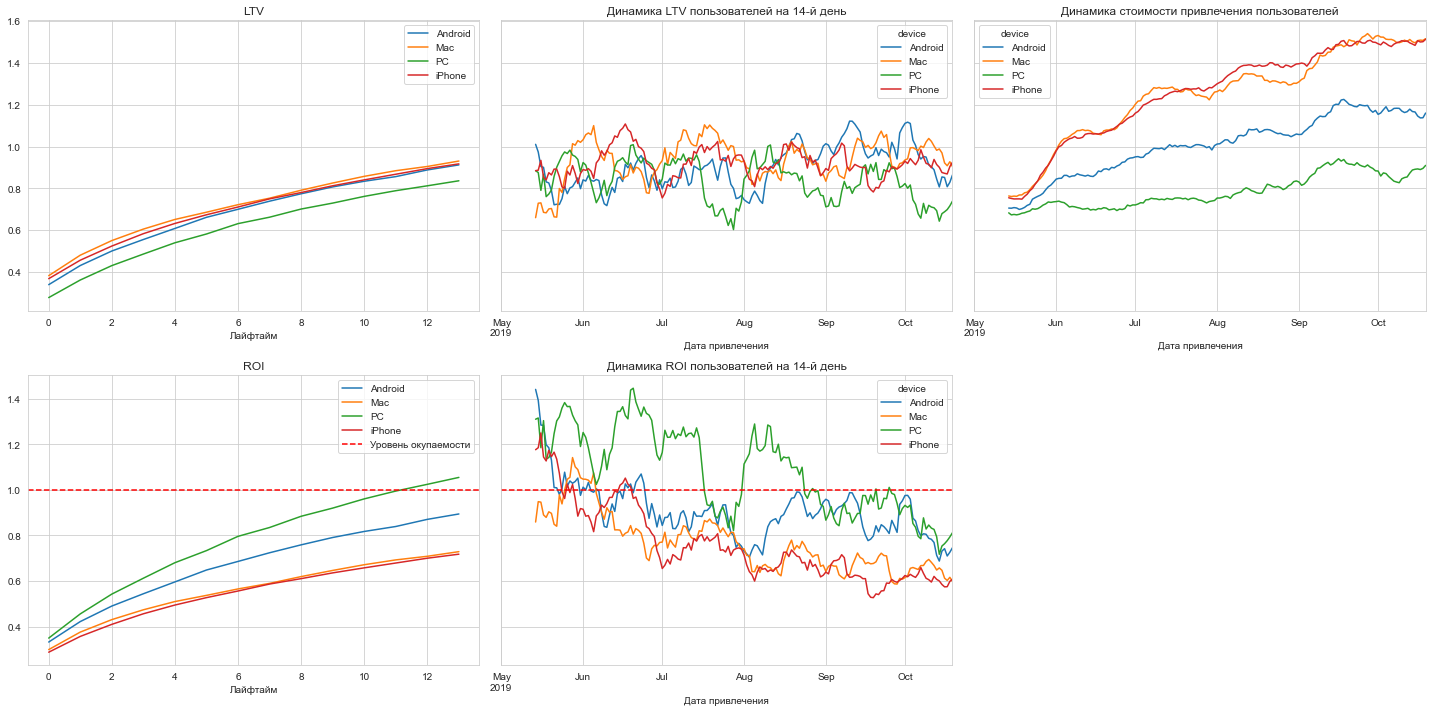

In [42]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- LTV стабилен.
- Окупаются только пользователи PC и не раньше, чем на 11-й день. У всех других устройств с окупаемостью проблема.
- На графике динамики ROI видим, что дела с окупаемостью пользователей Android и iPhone до июня были гораздо лучше.
- Стоимость привлечения пользователей растет для всех девайсов. Особенно для iPhone и Mac. Ниже всего CAC у владельцев PC.

В целом реклама не окупается. При этом расходы на нее постоянно растут. Очень сильно выросла стоимость привлечения пользователей из США, а также пользователей из канала "TipTop". Качество пользователей стабильно хорошее.

### Анализ конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам

Посчитаем и визуализируем конверсию с разбивкой по устройствам.

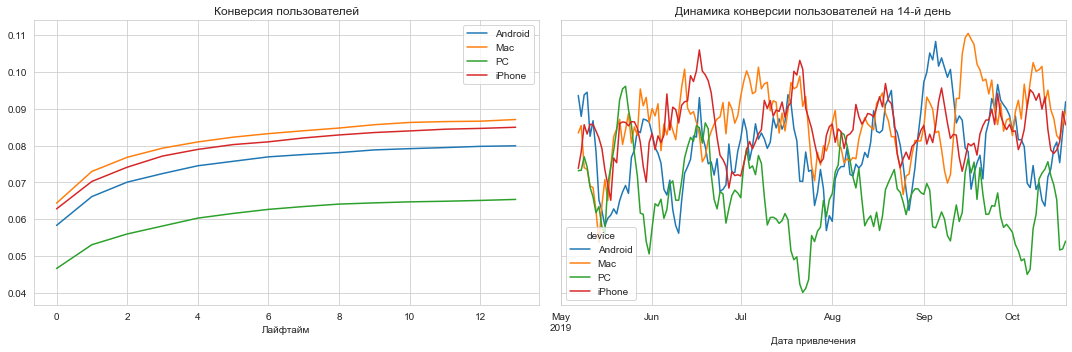

In [43]:
# смотрим конверсию с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Хуже всего обстоят дела с конверсией пользователей PC. Владельцы других устройств конвертируются стабильно хорошо. Посмотрим на удержание.

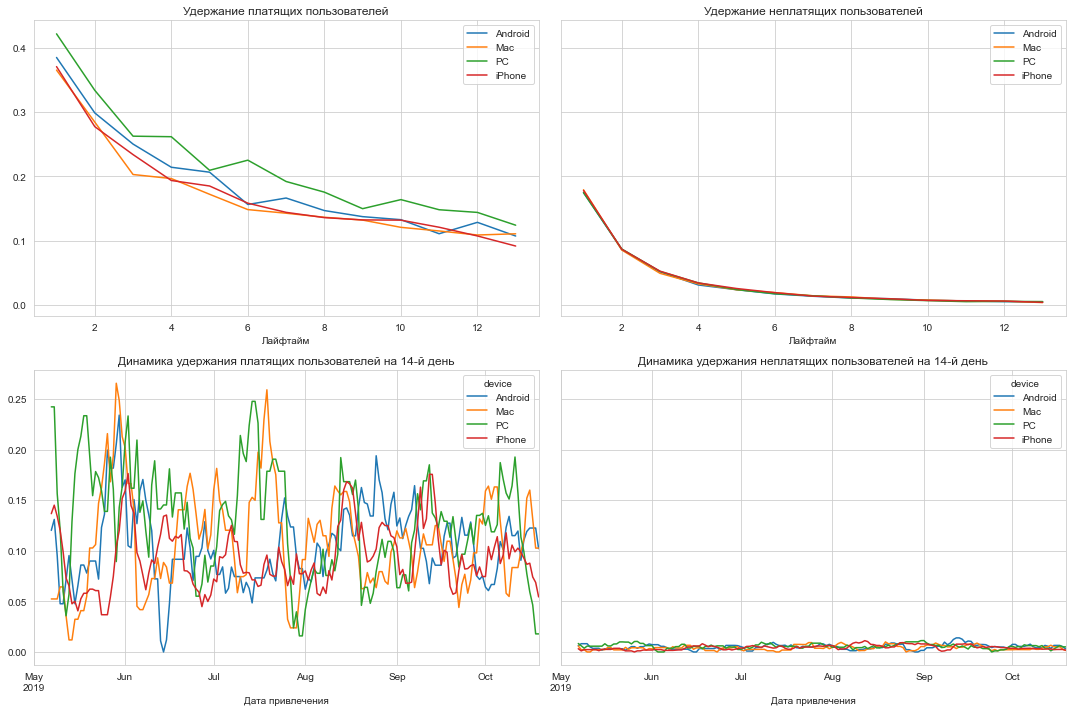

In [44]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Нельзя сказать, что удержание пользователей какого-либо устройства сильно выделяется на фоне других. Удержание неплатящих пользователей ожидаемо ниже, чем платящих.

Посчитаем и визуализируем конверсию с разбивкой по странам.

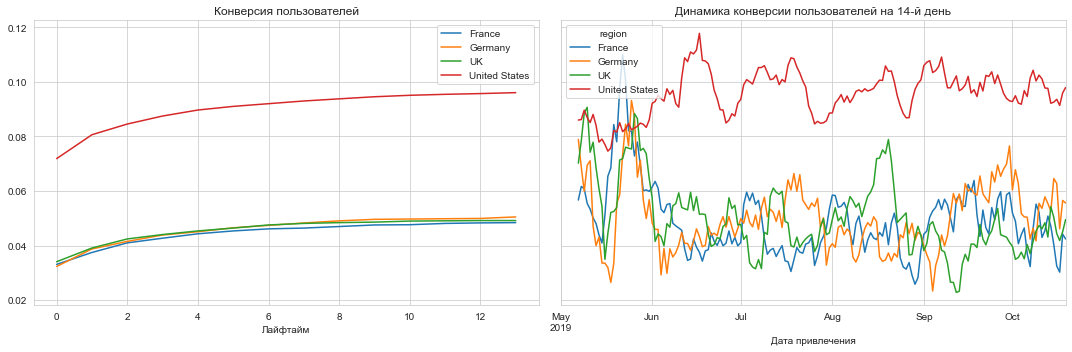

In [45]:
# смотрим конверсию с разбивкой по странам

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Лучше всего конверсия у пользователей из США, она примерно в два раза выше, чем у юзеров из других стран.

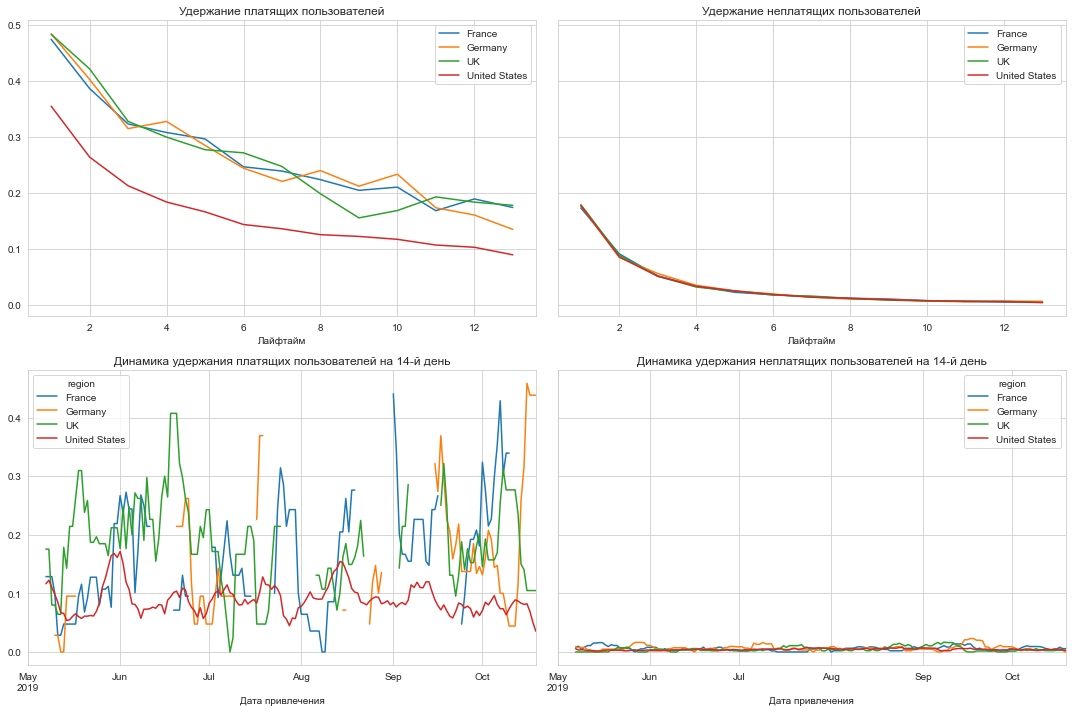

In [46]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

А вот что касается удержания, у пользователей из США оно заметно ниже, чем у остальных.

Посчитаем и визуализируем конверсию с разбивкой по рекламным каналам.

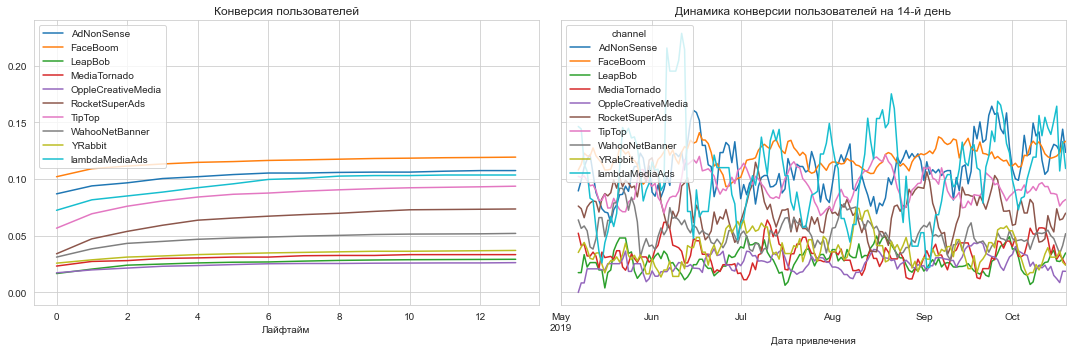

In [47]:
# смотрим конверсию с разбивкой по рекламным каналам

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Лучше всего конвертируются пользователи, привлеченные "FaceBoom".

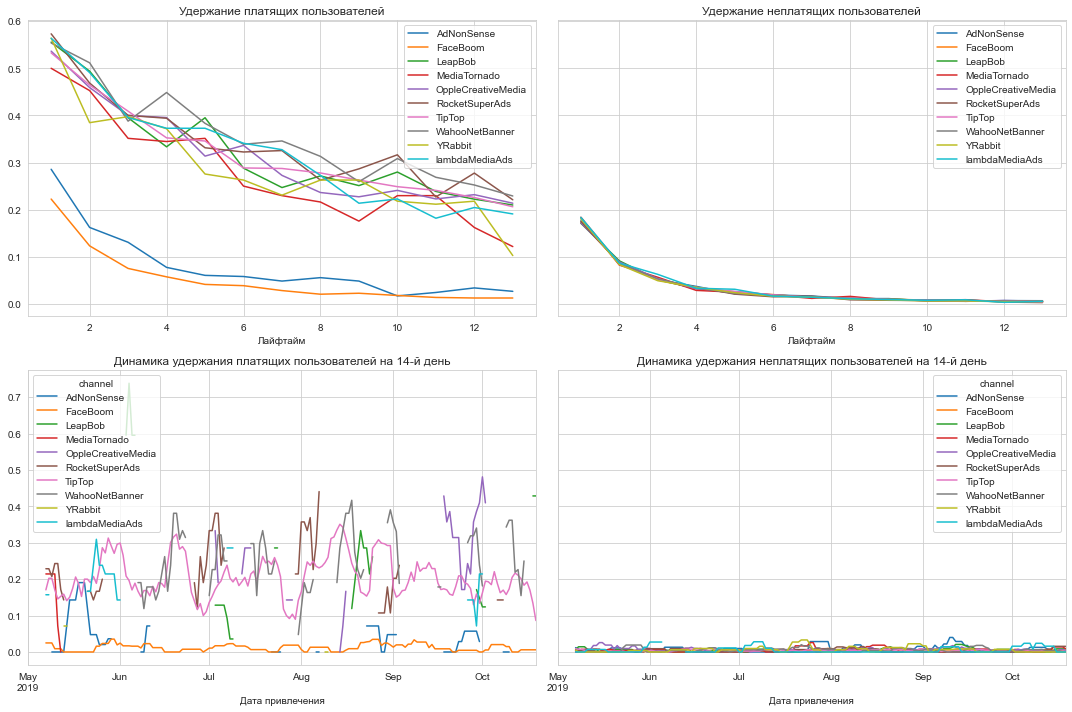

In [48]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Видим явные проблемы с удержанием пользователей из каналов "FaceBoom" и "AdNonSense".

Поскольку мы обнаружили значительные проблемы с окупаемостью и удержанием пользователей из США, построим для этой страны отдельные графики LTV и ROI, графики удержания и конверсии с разбивкой по каналам.</div>

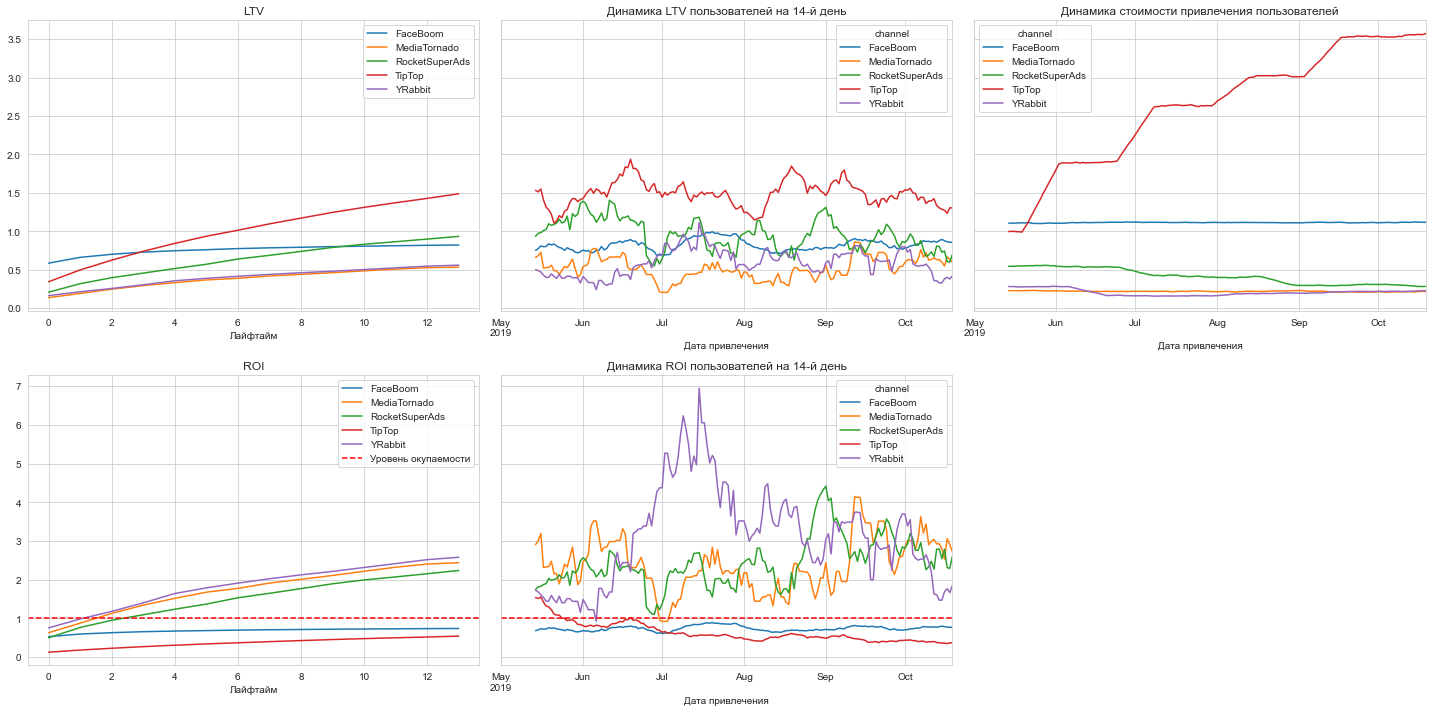

In [49]:
profiles_usa = profiles.query('region == "United States"')  # делаем срез

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Теперь мы видим, что причина неокупаемости пользователей из США в неокупаемости двух основных рекламных каналов - "TipTop" и "FaceBoom". Первый не окупается из-за высокой стоимости привлечения, а во втором, как мы помним, была проблема с удержанием пользователей. Все остальные каналы окупаются и CAC у них низкий и стабильный.

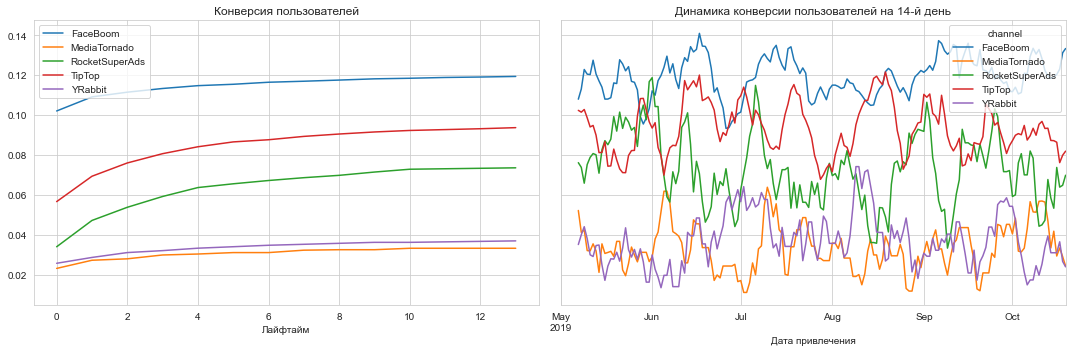

In [50]:
# смотрим конверсию для США с разбивкой по рекламным каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Выше всего коэффициент конверсии у "FaceBoom", неплохие показатели также у "TipTop" и "RocketSuperAds".

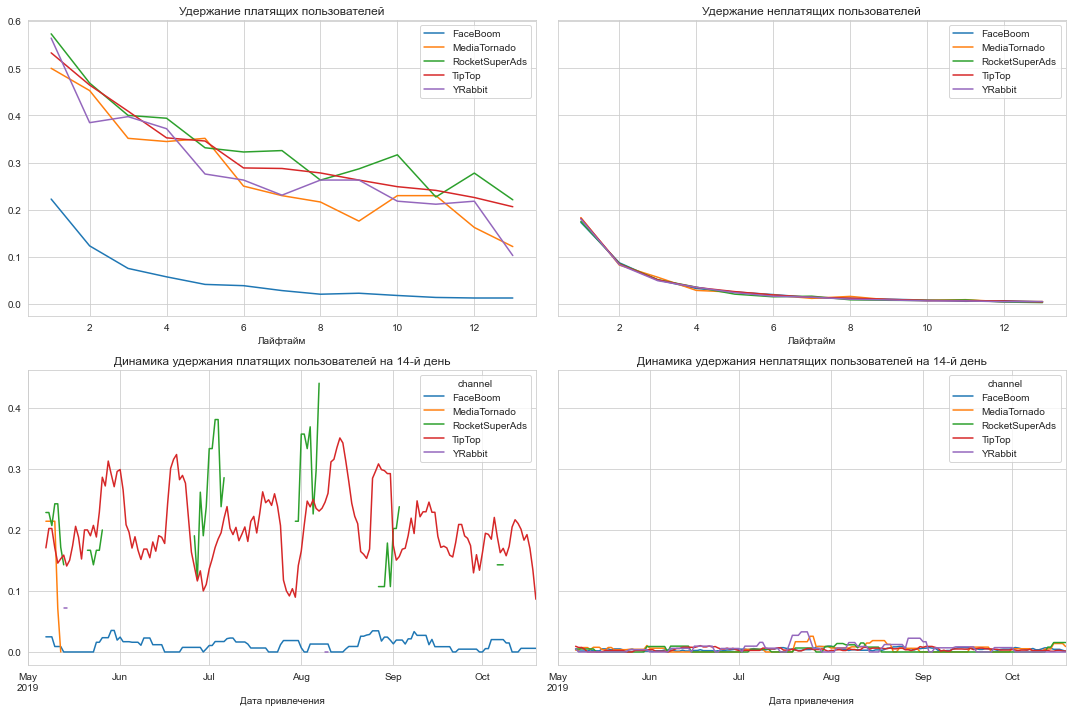

In [51]:
# смотрим удержание для США с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

А вот и причина низкого удержания пользователей из США. Один из двух основных каналов, по которым приходят пользователи этой страны, "FaceBoom", показывает очень низкий коэффициент удержания. У остальных каналов удержание примерно на одном уровне.


**Вывод:** В целом закупаемая компанией реклама приложения Procrastinate Pro+ не окупается. В бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения, а ROI в конце второй недели составляет только 80%. Снижают окупаемость непомерные затраты на такие рекламные источники как "TipTop" и "FaceBoom". Также не окупаются (плохо удерживаются) пользователи из США и владельцы Mac и iPhone. Главной причиной такой плохой окупаемости по всей видимости выступает неправильно распределенный рекламный бюджет - более 80% рекламы закупается в двух источниках, которые не дают нужной отдачи.

## Вывод

### Причины неэффективности привлечения пользователей

Как было отмечено выше, причина убытков компании кроется в неправильном распределении средств, выделенных на рекламу. Больше 80% рекламного бюджета тратится на каналах "TipTop" и "FaceBoom". В "TipTop" каждый месяц вкладывается все больше и больше денег, но он не приносит достаточно пользователей - CAC для этого канала только растет. По всем графикам видим, что переломный момент случился еще в июне - тогда было куплено рекламы больше, чем обычно (в "TipTop" и "FaceBoom"), но она не дала 'выхлопа'. Судя по всему, после этого было принято неправильное решение - закупить еще больше рекламы, чтобы покрыть недостачу, но убытки продолжали расти как снежный ком. Кроме того, пользователи, пришедшие от "FaceBoom" очень плохо удерживаются (такая же проблема у канала "AdNonsense").     

### Рекомендации для отдела маркетинга

Маркетологам компании следует пересмотреть бюджет, отведенный на рекламу, и вместо закупки большого объема рекламы в 1-2 источниках, распредилить средства равномерно. Стоить уделить больше внимания каналам, покупка рекламы на которых хорошо окупается, а стоимость привлечения одного клиента стабильно низкая. Этим параметрам удовлетворяет, например, канал "YRabbit". Но опять же повторимся, что рассчитывать только на один источник привлечения пользователей не стоит.

Кроме того, необходимо разобраться в плохой окупаемости пользователей из США, тем более, что пользователи из этой страны составляют бо́льшую часть аудитории приложения и лучше остальных конвертируются в плательщиков. Стоимость привлечения пользователей из США гораздо выше, чем в других странах, и еще продолжает расти. Это связано с тем, что пользователи из США приходят в основном с каналов "TipTop" и "FaceBoom". Также клиенты из США плохо удерживаются в приложении, эту проблему создает канал "FaceBoom". Для привлечения пользователей из США необходимо изменить рекламные источники - так, канал "RocketSupersAds" удовлетворяет всем требуемым параметрам - низкая стоимость привлечения пользователей, хорошая окупаемость, стабильные конверсия и удержание. 
Пользователи из других стран стабильно хорошо окупаются и удерживаются. Нужно попробовать привлечь больше пользователей из Германии, Франции и Великобритании, закупив трафик на других источниках.

Также стоит обратить внимание на неокупаемость рекламы для владельцев iPhone и Mac - с их конверсией и удержанием все в порядке, а вот CAC продолжает расти. Следует поработать над конверсией пользователей PC - она заметно ниже остальных - например, сделать специальное маркетинговое предложение для владельцев данных устройств.